# Volatility Forecasting

_This setup code is required to run in an IPython notebook_

In [1]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import seaborn
seaborn.set_style('darkgrid')

In [2]:
seaborn.mpl.rcParams['figure.figsize'] = (10.0, 6.0)
seaborn.mpl.rcParams['savefig.dpi'] = 90
seaborn.mpl.rcParams['font.family'] = 'serif'
seaborn.mpl.rcParams['font.size'] = 14

## Data
These examples make use of S&P 500 data from Yahoo! using the pandas-datareader package to manage data download.

In [3]:
import datetime as dt
import sys

import numpy as np
import pandas as pd
import pandas_datareader.data as web

from arch import arch_model

start = dt.datetime(2000,1,1)
end = dt.datetime(2017,1,1)
data = web.get_data_famafrench('F-F_Research_Data_Factors_daily', start=start, end=end)
mkt_returns = data[0]['Mkt-RF'] +  data[0]['RF']
returns = mkt_returns

## Basic Forecasting
Forecasts can be generated for standard GARCH(p,q) processes using any of the three forecast generation methods:

* Analytical
* Simulation-based
* Bootstrap-based

Be default forecasts will only be produced for the final observation in the sample so that they are out-of-sample.

Forecasts start with specifying the model and estimating parameters.

In [4]:
am = arch_model(returns, vol='Garch', p=1, o=0, q=1, dist='Normal')
res = am.fit(update_freq=5)

Iteration:      5,   Func. Count:     39,   Neg. LLF: 6130.463290480577
Iteration:     10,   Func. Count:     71,   Neg. LLF: 6128.47317714312
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6128.473168195432
            Iterations: 11
            Function evaluations: 77
            Gradient evaluations: 11


In [5]:
forecasts = res.forecast()

Forecasts are contained in an `ARCHModelForecast` object which has 4 attributes:

* `mean` - The forecast means
* `residual_variance` - The forecast residual variances, that is $E_t[\epsilon_{t+h}^2]$
* `variance` - The forecast variance of the process, $E_t[r_{t+h}^2]$.  The variance will differ from the residual variance whenever the model has mean dynamics, e.g., in an AR process.
* `simulations` - An object that contains detailed information about the simulations used to generate forecasts.  Only used if the forecast `method` is set to `'simulation'` or `'bootstrap'`.  If using `'analytical'` (the default), this is `None`.

The three main outputs are all returned in `DataFrame`s with columns of the form `h.#` where `#` is the number of steps ahead.  That is, `h.1` corresponds to one-step ahead forecasts while `h.10` corresponds to 10-steps ahead.

The default forecast only produces 1-step ahear forecasts.

In [6]:
print(forecasts.mean.iloc[-3:])
print(forecasts.residual_variance.iloc[-3:])
print(forecasts.variance.iloc[-3:])

                 h.1
Date                
2016-12-28       NaN
2016-12-29       NaN
2016-12-30  0.061285
                 h.1
Date                
2016-12-28       NaN
2016-12-29       NaN
2016-12-30  0.400956
                 h.1
Date                
2016-12-28       NaN
2016-12-29       NaN
2016-12-30  0.400956


Longer horizon forecasts can be computed by passing the parameter `horizon`.

In [7]:
forecasts = res.forecast(horizon=5)
print(forecasts.residual_variance.iloc[-3:])

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2016-12-28       NaN       NaN       NaN       NaN       NaN
2016-12-29       NaN       NaN       NaN       NaN       NaN
2016-12-30  0.400956  0.416563  0.431896  0.446961  0.461762


Values that are not computed are ``nan``-filled.

## Alternative Forecast Generation Schemes

### Fixed Window Forecasting

Fixed-windows forecasting uses data up to a specified date to generate all forecasts after that date. This cna be implemented by passing the entire data in when initializing the model and then using ``last_obs`` when calling ``fit``.  ``forecast()`` will, by default, produce forecasts after this final date.

**Note** ``last_obs`` follow Python sequence rules so that the actual date in ``last_obs`` is not in the sample.

In [8]:
res = am.fit(last_obs = '2011-1-1', update_freq=5)
forecasts = res.forecast(horizon=5)
print(forecasts.variance.dropna().head())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 4204.91956121224
Iteration:     10,   Func. Count:     72,   Neg. LLF: 4202.815024845146
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4202.812110685669
            Iterations: 12
            Function evaluations: 84
            Gradient evaluations: 12
                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2010-12-31  0.365727  0.376462  0.387106  0.397660  0.408124
2011-01-03  0.451526  0.461532  0.471453  0.481290  0.491043
2011-01-04  0.432131  0.442302  0.452387  0.462386  0.472300
2011-01-05  0.430051  0.440239  0.450341  0.460358  0.470289
2011-01-06  0.407841  0.418219  0.428508  0.438710  0.448825


### Rolling Window Forecasting

Rolling window forecasts use a fixed sample length and then produce one-step from the final observation.  These can be implemented using ``first_obs`` and ``last_obs``.

In [9]:
index = returns.index
start_loc = 0
end_loc = np.where(index >= '2010-1-1')[0].min()
forecasts = {}
for i in range(20):
    sys.stdout.write('.')
    sys.stdout.flush()
    res = am.fit(first_obs=i, last_obs=i+end_loc, disp='off')
    temp = res.forecast(horizon=3).variance
    fcast = temp.iloc[i+end_loc-1]
    forecasts[fcast.name] = fcast
print()
print(pd.DataFrame(forecasts).T)

....................
                 h.1       h.2       h.3
2009-12-31  0.598199  0.605960  0.613661
2010-01-04  0.771974  0.778431  0.784837
2010-01-05  0.724185  0.731008  0.737781
2010-01-06  0.674237  0.681423  0.688555
2010-01-07  0.637534  0.644995  0.652399
2010-01-08  0.601684  0.609451  0.617161
2010-01-11  0.562393  0.570450  0.578447
2010-01-12  0.613401  0.621098  0.628738
2010-01-13  0.623059  0.630676  0.638236
2010-01-14  0.584403  0.592291  0.600119
2010-01-15  0.654097  0.661483  0.668813
2010-01-19  0.725471  0.732355  0.739187
2010-01-20  0.758532  0.765176  0.771770
2010-01-21  0.958742  0.964005  0.969229
2010-01-22  1.272999  1.276121  1.279220
2010-01-25  1.182257  1.186084  1.189883
2010-01-26  1.110357  1.114637  1.118885
2010-01-27  1.044077  1.048777  1.053442
2010-01-28  1.085489  1.089873  1.094223
2010-01-29  1.088349  1.092875  1.097367


### Recursive Forecast Generation

Recursive is similar to rolling except that the initial observation doesn't change.  This can be easily implemented by dropping the ``first_obs`` input.

In [10]:
import pandas as pd
import numpy as np
index = returns.index
start_loc = 0
end_loc = np.where(index >= '2010-1-1')[0].min()
forecasts = {}
for i in range(20):
    sys.stdout.write('.')
    sys.stdout.flush()
    res = am.fit(last_obs=i+end_loc, disp='off')
    temp = res.forecast(horizon=3).variance
    fcast = temp.iloc[i+end_loc-1]
    forecasts[fcast.name] = fcast
print()
print(pd.DataFrame(forecasts).T)

....................
                 h.1       h.2       h.3
2009-12-31  0.598199  0.605960  0.613661
2010-01-04  0.772200  0.778629  0.785009
2010-01-05  0.723347  0.730126  0.736853
2010-01-06  0.673796  0.680934  0.688017
2010-01-07  0.637555  0.644959  0.652306
2010-01-08  0.600834  0.608511  0.616129
2010-01-11  0.561436  0.569411  0.577324
2010-01-12  0.612214  0.619798  0.627322
2010-01-13  0.622095  0.629604  0.637055
2010-01-14  0.583425  0.591215  0.598945
2010-01-15  0.652960  0.660231  0.667447
2010-01-19  0.724212  0.730968  0.737673
2010-01-20  0.757280  0.763797  0.770264
2010-01-21  0.956394  0.961508  0.966583
2010-01-22  1.268445  1.271402  1.274337
2010-01-25  1.177405  1.180991  1.184549
2010-01-26  1.106326  1.110404  1.114450
2010-01-27  1.040930  1.045462  1.049959
2010-01-28  1.082130  1.086370  1.090577
2010-01-29  1.082251  1.086487  1.090690


## TARCH

### Analytical Forecasts

All ARCH-type models have one-step analytical forecasts.  Longer horizons only have closed forms for specific models.  TARCH models do not have closed-form (analytical) forecasts for horizons larger than 1, and so simulation or bootstrapping is required.  Attempting to produce forecasts for horizons larger than 1 using `method='analytical'` results in a `ValueError`. 

In [11]:
# TARCH specification
am = arch_model(returns, vol='GARCH', power=2.0, p=1, o=1, q=1)
res = am.fit(update_freq=5)
forecasts = res.forecast()
print(forecasts.variance.iloc[-1])

Iteration:      5,   Func. Count:     44,   Neg. LLF: 6037.930348216891
Iteration:     10,   Func. Count:     82,   Neg. LLF: 6034.462050551085
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6034.461795250723
            Iterations: 12
            Function evaluations: 96
            Gradient evaluations: 12
h.1    0.449483
Name: 2016-12-30 00:00:00, dtype: float64


### Simulation Forecasts

When using simulation- or bootstrap-based forecasts, an additional attribute of an `ARCHModelForecast` object is meaningful -- `simulation`.

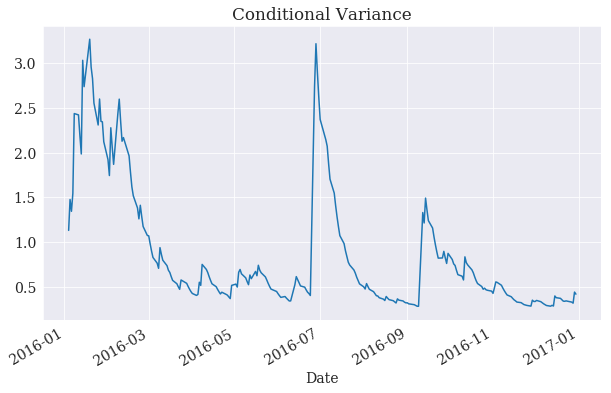

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
subplot = (res.conditional_volatility['2016'] ** 2.0).plot(ax=ax, title='Conditional Variance')

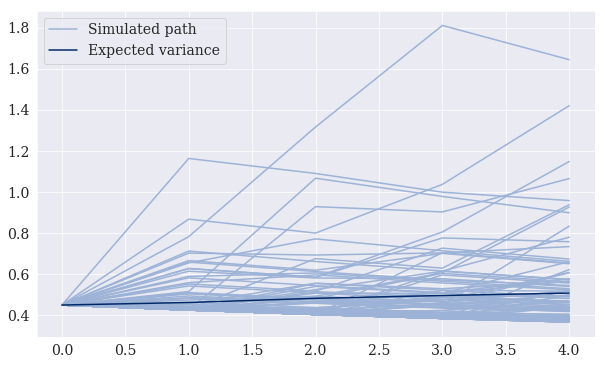

In [13]:
forecasts = res.forecast(horizon=5, method='simulation')
sims = forecasts.simulations

lines = plt.plot(sims.residual_variances[-1,::10].T, color='#9cb2d6')
lines[0].set_label('Simulated path')
line = plt.plot(forecasts.variance.iloc[-1].values, color='#002868')
line[0].set_label('Expected variance')
legend = plt.legend()

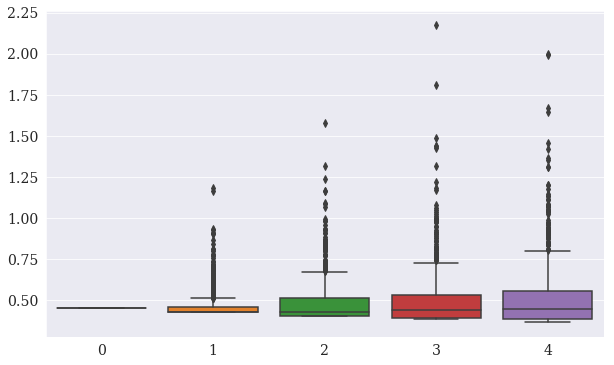

In [14]:
import seaborn as sns
sns.boxplot(data=sims.variances[-1])

### Bootstrap Forecasts

Bootstrap-based forecasts are nearly identical to simulation-based forecasts except that the values used to simulate the process are computed from historical data rather than using the assumed distribution of the residuals. Forecasts produced using this method also return an `ARCHModelForecastSimulation` containing information about the simulated paths.

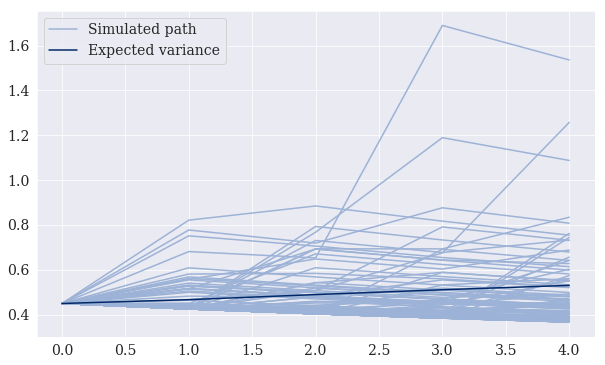

In [15]:
forecasts = res.forecast(horizon=5, method='bootstrap')
sims = forecasts.simulations

lines = plt.plot(sims.residual_variances[-1,::10].T, color='#9cb2d6')
lines[0].set_label('Simulated path')
line = plt.plot(forecasts.variance.iloc[-1].values, color='#002868')
line[0].set_label('Expected variance')
legend = plt.legend()